In [38]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from statsforecast import StatsForecast
from datasetsforecast.losses import mae, mape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Preprocess Data

In [39]:
# Load data
df = pd.read_csv("../data/raw/Air_Traffic_Passenger_Statistics.csv")

# Data Preprocessing
df = df.drop(columns=['Operating Airline IATA Code', 'Published Airline IATA Code', 'data_as_of', 'data_loaded_at']).reset_index(drop=True)
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])
df = df.groupby(by=['Activity Period Start Date']).agg({'Passenger Count': 'sum'}).reset_index()
df = df.rename(columns={
    "Activity Period Start Date": "date",
    "Passenger Count": "passenger_count"
})

# Split data Pre and Post Covid 19 Pandemic
1. The reason we split it because due to behavior of the passengers are different between pre and post Covid 19 Pandemic. 
2. From previous EDA, the trend of the data and the pattern of seasonality for both are different. 

In [3]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-01-01'
df_pre_covid = df[df['date']<break_point]
df_post_covid = df[df['date']>=break_point]

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<='2019-01-01']
test_pre_covid = df_pre_covid[df_pre_covid['date']>'2019-01-01']
train_post_covid = df_post_covid[df_post_covid['date']<='2022-12-01']
test_post_covid = df_post_covid[df_post_covid['date']>'2022-12-01']

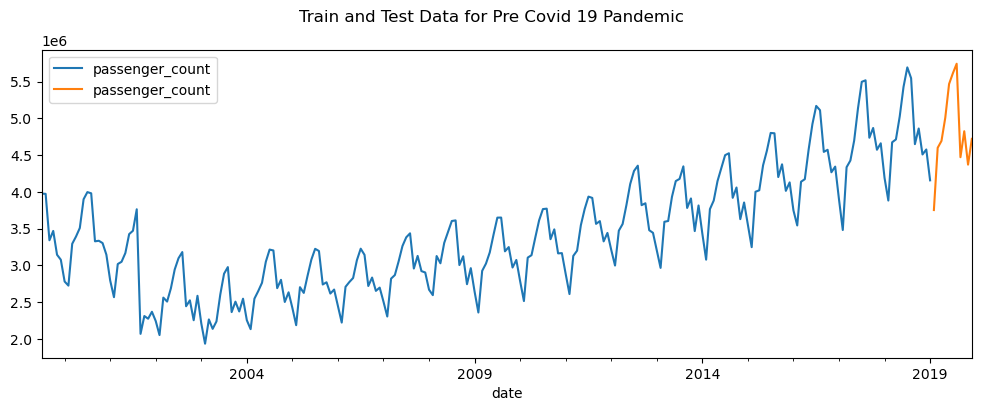

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
train_pre_covid.set_index('date').plot(ax=ax, label='train')
test_pre_covid.set_index('date').plot(ax=ax, label='test')
fig.suptitle("Train and Test Data for Pre Covid 19 Pandemic")
plt.show()

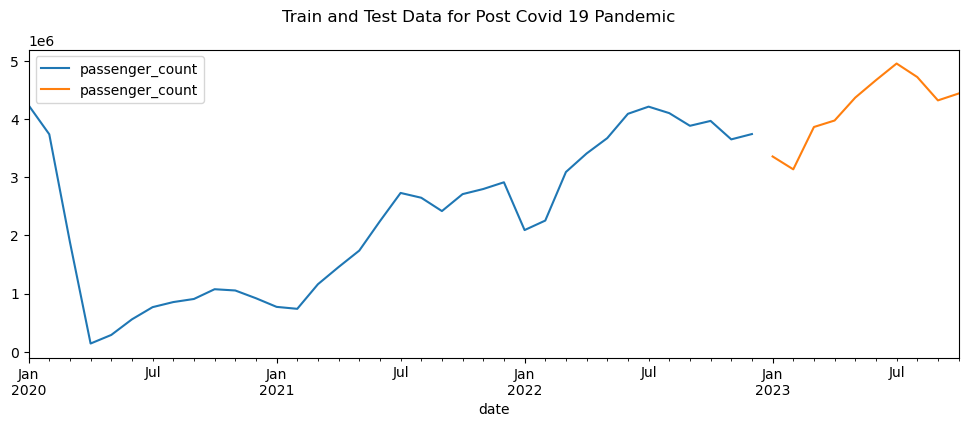

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
train_post_covid.set_index('date').plot(ax=ax, label='train')
test_post_covid.set_index('date').plot(ax=ax, label='test')
fig.suptitle("Train and Test Data for Post Covid 19 Pandemic")
plt.show()

# Data Preparation for Modelling

In [81]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-01-01'
df_pre_covid = df[df['date']<break_point]
df_pre_covid['unique_id'] = 1
df_post_covid = df[df['date']>=break_point]
df_post_covid['unique_id'] = 1

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<'2019-01-01'].reset_index(drop=True)
test_pre_covid = df_pre_covid[df_pre_covid['date']>='2019-01-01'].reset_index(drop=True)
train_post_covid = df_post_covid[df_post_covid['date']<'2023-01-01'].reset_index(drop=True)
test_post_covid = df_post_covid[df_post_covid['date']>='2023-01-01'].reset_index(drop=True)
train_pre_covid = train_pre_covid.rename(columns={'date': 'ds', 'passenger_count': 'y'})
test_pre_covid = test_pre_covid.rename(columns={'date': 'ds', 'passenger_count': 'y_test'})
train_post_covid = train_post_covid.rename(columns={'date': 'ds', 'passenger_count': 'y'})
test_post_covid = test_post_covid.rename(columns={'date': 'ds', 'passenger_count': 'y_test'})

C:\Users\USER\AppData\Local\Temp\ipykernel_18384\1590927659.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_18384\1590927659.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Baseline Model

## Pre Covid

In [82]:
from statsforecast.models import Naive, HistoricAverage, SeasonalNaive

models = [
    Naive(),
    HistoricAverage(),
    SeasonalNaive(season_length=12),
]

sf = StatsForecast(
    models=models,
    freq='MS',
    df=train_pre_covid
)

start = time.time()
sf.fit()
end = time.time()
print(f"Finished Fitting, took about {end-start:.2f} seconds")

Finished Fitting, took about 0.00 seconds


In [83]:
start = time.time()
forecast = sf.forecast(h=12).reset_index()
forecast = test_pre_covid.merge(forecast, on=['unique_id', 'ds'])
end = time.time()
print(f"Finished Fitting, took about {end-start:.2f} seconds")

Finished Fitting, took about 0.01 seconds


c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning:

invalid value encountered in cast



In [84]:
StatsForecast.plot(train_pre_covid[-50:], forecast)

## Post Covid

In [85]:
from statsforecast.models import Naive, HistoricAverage, SeasonalNaive

models = [
    Naive(),
    HistoricAverage(),
    SeasonalNaive(season_length=12),
]

sf = StatsForecast(
    models=models,
    freq='MS',
    df=train_post_covid
)

start = time.time()
sf.fit()
end = time.time()
print(f"Finished Fitting, took about {end-start:.2f} seconds")

Finished Fitting, took about 0.00 seconds


In [86]:
start = time.time()
forecast = sf.forecast(h=12).reset_index()
forecast = test_post_covid.merge(forecast, on=['unique_id', 'ds'])
end = time.time()
print(f"Finished Fitting, took about {end-start:.2f} seconds")

Finished Fitting, took about 0.01 seconds


c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning:

invalid value encountered in cast



In [87]:
StatsForecast.plot(train_post_covid[-20:], forecast)

In [89]:
uids = test_post_covid.unique_id.unique()
unique_ids = []
methods = []
maes = []
mapes = []
for method in models:
    for uid in uids:
        filtered_test = test_post_covid[test_post_covid['unique_id']==uid]
        filtered_forecast = forecast[forecast['unique_id']==uid]
        
        unique_ids.append(uid)
        methods.append(method.__class__.__name__)
        maes.append(mae(filtered_test['y_test'], filtered_forecast[method.__class__.__name__]))
        mapes.append(mape(filtered_test['y_test'], filtered_forecast[method.__class__.__name__]))

eval_df = pd.DataFrame({
    'unique_id': unique_ids,
    'method': methods,
    'mae': maes,
    'mape': mapes
})

eval_df

,unique_id,method,mae,mape
0,1,Naive,637673.1,14.838754
1,1,HistoricAverage,1880575.9,43.815892
2,1,SeasonalNaive,704244.7,17.732459
